# Assignment: Cost-Aware Compaction Strategy for Apache Iceberg

## Problem Statement

In large-scale data platforms like **Apache Iceberg**, data is organized into **partitions**, and over time, these partitions accumulate small files and delete markers. This degrades query performance and increases infrastructure costs.

To maintain performance, **file compaction** is used to merge small and deleted files into optimized, larger ones. However, compaction itself is compute-intensive and expensive. The challenge is to **select only those partitions for compaction** that give **maximum performance benefit within a limited compute budget**.


## Objective

For **each partition**, decide:

* Whether to compact it or not

Such that:

* **Total compaction cost ≤ daily compute budget**
* **Total performance gain is maximized**


## Dataset Description

Each row in the dataset represents one partition and contains:

| Column                       | Description                            |
| ---------------------------- | -------------------------------------- |
| `file_count`                 | Total number of files in the partition |
| `avg_file_size_mb`           | Average size of files in MB            |
| `delete_file_count`          | Number of delete files                 |
| `delete_ratio`               | `delete_file_count / file_count`       |
| `avg_delete_file_size_mb`    | Average size of delete files in MB     |
| `partition_access_frequency` | How often the partition is queried     |
| `small_files_count`          | Number of files smaller than 128 MB    |


## Key Concepts & Assumptions

1. **Small Files Penalty**

   * More small files ⇒ worse query performance
   * Penalty ∝ `small_files_count`
   * Penalty ∝ `1 / avg_file_size_mb`

2. **Delete File Penalty**

   * Delete files add read overhead
   * Penalty ∝ `delete_file_count × avg_delete_file_size_mb`

3. **Access-Weighted Penalty**

   * Frequently accessed partitions should be prioritized
   * All penalties are scaled by `partition_access_frequency`

4. **Compaction Cost**

   * Defined as:

     ```
     compaction_cost = file_count × avg_file_size_mb × avg_delete_file_size_mb × cost_factor
     ```
   * `cost_factor = 0.001` to normalize into minutes


## Constraints

* **Daily Compute Budget** = `3000 minutes` (i.e., 50 compute-hours)
* Only select partitions whose **total cost ≤ budget**


## Goal

Develop an **optimization algorithm** that:

* Computes a **penalty score** for each partition
* Computes the **cost to compact** each partition
* Selects a subset of partitions that **maximize penalty reduction**
* Ensures total cost stays **within budget**



### 1. Import Libraries and Load Data
We import required libraries and load the sample dataset (JSON) into a DataFrame.


In [67]:
# Import Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt


In [68]:
with open("sample.json", "r") as f:
    data = json.load(f)
    
df = pd.DataFrame(data)


### 2. Penalty Function

We define a **Penalty** to capture the inefficiency of a partition. It increases with:

- Number of small files (weighted heavily),
- Number and size of delete files (moderately weighted),
- How frequently the partition is accessed (higher frequency = more penalty).

**Formula:**

$$
\text{Penalty} = \left( \text{small\_file\_count} \times 2 + \text{delete\_file\_count} \times \text{avg\_delete\_file\_size\_mb} \times 0.3 \right) \times \text{partition\_access\_frequency}
$$



In [69]:
def compute_penalty(row):
    return (
        row['small_file_count'] * 2 +
        row['delete_file_count'] * row['avg_delete_file_size_mb'] * 0.3
    ) * row['partition_access_frequency']


### 3. Cost Function

The **cost** of compacting a partition is estimated based on:
- Total number of files,
- Average file size,
- Average delete file size,
- And a scaling factor (COST_FACTOR = 0.001).

### Formula:

$$
\text{Cost} = \text{file\_count} \times \text{avg\_file\_size\_mb} \times \text{avg\_delete\_file\_size\_mb} \times \text{COST\_FACTOR}
$$

Where:
- `file_count` = Total files in the partition  
- `avg_file_size_mb` = Average size of files (in MB)  
- `avg_delete_file_size_mb` = Average size of delete files (in MB)  
- `COST_FACTOR` = 0.001 (a tuning parameter to scale the cost)


In [70]:
COST_FACTOR = 0.001

def compute_cost(row):
    return (
        row['file_count'] *
        row['avg_file_size_mb'] *
        row['avg_delete_file_size_mb'] *
        COST_FACTOR
    )


### 4. Calculating Penalty, Cost, and Score

We compute three key metrics for each partition:

1. **Penalty** – Measures inefficiency based on small files, delete files, and access frequency.
2. **Cost** – Estimated compute cost to compact the partition.
3. **Score** – Ratio of performance penalty to cost. Higher score means better value for compaction.

In [71]:
# Add columns
df['penalty'] = df.apply(compute_penalty, axis=1)
df['cost'] = df.apply(compute_cost, axis=1)
df['score'] = df['penalty'] / (df['cost'] + 1e-6) 

### 5. Performance Penalty vs. Compaction Cost (Scatter Plot)

This scatter plot helps us visualize the **cost–benefit trade-off** for compacting each partition.

* **X-axis**: Estimated **Compaction Cost** (in compute units). Higher values mean more resources are required to compact that partition.
* **Y-axis**: Estimated **Performance Penalty Score**. Higher scores indicate that a partition is causing more performance issues (e.g., due to small files, deletes, frequent access).


### Why This Graph Matters

* It reveals **which partitions give the most benefit** for the least cost.
* **Top-left quadrant**:  **High penalty, low cost** → ideal compaction targets (e.g., `partition_9`, `partition_17`)
* **Bottom-right quadrant**:  **Low penalty, high cost** → low ROI for compaction (e.g., `partition_3`)
* This lets data teams **visually prioritize** where to spend limited compute budget.


### Technical Context

This graph is based on:

* A **computed penalty score** derived from:

  * Number of small files
  * Delete file count and sizes
  * Partition access frequency
* A **cost estimate**, which scales with total MB to process
* Each partition is a **data point**, labeled by ID for easy lookup.

By plotting penalty against cost, this graph shows:

> *“How much performance benefit do we gain per unit of compaction cost?”*

This supports **data-driven optimization**, replacing guesswork with visual reasoning.

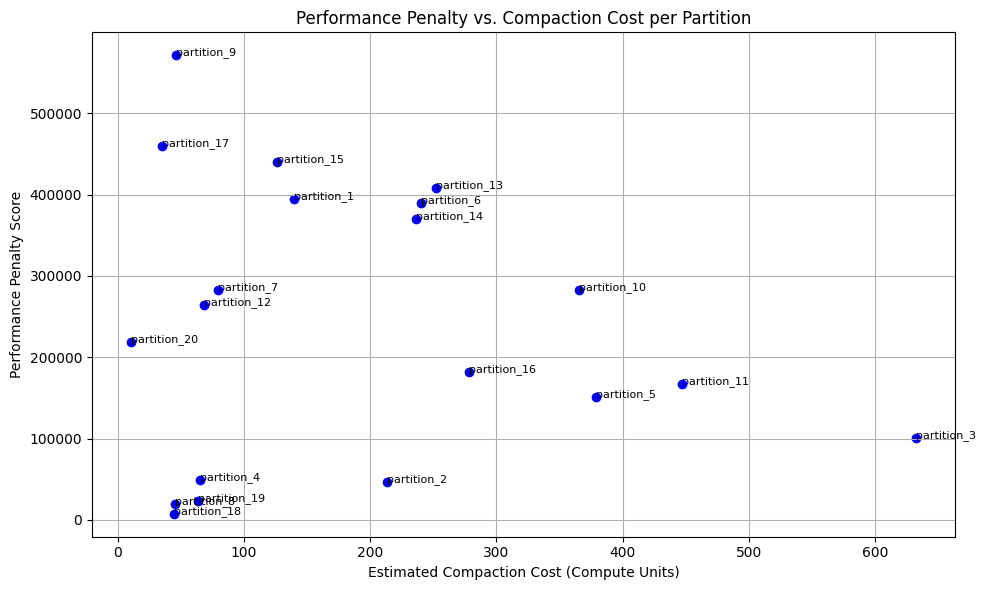

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(df['cost'], df['penalty'], color='blue')

# Annotate each point with its partition ID
for _, row in df.iterrows():
    plt.text(row['cost'], row['penalty'], row['partition_id'], fontsize=8)

plt.title("Performance Penalty vs. Compaction Cost per Partition")
plt.xlabel("Estimated Compaction Cost (Compute Units)")
plt.ylabel("Performance Penalty Score")
plt.grid(True)
plt.tight_layout()

# Save plot
plt.show()

In [73]:
df_sorted = df.sort_values(by='score', ascending=False)
df_sorted.head()

,partition_id,file_count,avg_file_size_mb,total_size_mb,delete_file_count,delete_ratio,avg_delete_file_size_mb,partition_access_frequency,small_file_count,penalty,cost,score
19,partition_20,131,15.27,1999.81,58,0.44,5.39,711,107,218835.846,10.781994,20296.414524
16,partition_17,395,12.05,4760.93,83,0.21,7.45,568,312,459798.840,35.460138,12966.639710
8,partition_9,358,16.37,5859.82,14,0.04,7.92,941,287,571435.424,46.414843,12311.479955
11,partition_12,332,50.63,16810.20,7,0.02,4.08,469,278,264782.392,68.581373,3860.849927
6,partition_7,321,85.39,27411.27,23,0.07,2.91,511,267,283134.369,79.763653,3549.666485


In [74]:
# Select partitions under budget
BUDGET = 3000  # change based on scenario
selected_partitions = []
selected_rows = []
total_cost = 0.0
total_penalty = 0

In [75]:
for _, row in df_sorted.iterrows():
    if total_cost + row['cost'] <= BUDGET:
        selected_partitions.append(row['partition_id'])
        selected_rows.append(row)
        total_cost += row['cost']
        total_penalty += row['penalty']

In [78]:
# Final Selected Partitions Summary
selected_df = pd.DataFrame(selected_rows)

total_penalty_before = round(df['penalty'].sum(), 2)
total_penalty_avoided = round(total_penalty, 2)  # already calculated from selected
penalty_remaining = round(total_penalty_before - total_penalty_avoided, 2)

print("Total Cost Consumed:", round(total_cost, 2))
print("Total Penalty Before Compaction:", total_penalty_before)
print("Expected Performance Gain (Penalty Avoided):", total_penalty_avoided)
print("Penalty Remaining (Still Unoptimized):", penalty_remaining)
print("Partitions Selected:", selected_partitions)
print("Number of Selected Partitions:", len(selected_partitions))


Total Cost Consumed: 2926.13
Total Penalty Before Compaction: 4829978.66
Expected Performance Gain (Penalty Avoided): 4682571.39
Penalty Remaining (Still Unoptimized): 147407.27
Partitions Selected: ['partition_20', 'partition_17', 'partition_9', 'partition_12', 'partition_7', 'partition_15', 'partition_1', 'partition_6', 'partition_13', 'partition_14', 'partition_10', 'partition_4', 'partition_16', 'partition_8', 'partition_5', 'partition_11', 'partition_19', 'partition_18']
Number of Selected Partitions: 18


## Final Compaction Results

After applying the score-based greedy compaction strategy under a limited compute budget, the following outcomes were achieved:

- **Total Cost Consumed**: `2926.13` minutes  
  Efficiently used the compute budget (3000 mins) without exceeding it.

- **Expected Performance Gain (Penalty Avoided)**: `4,682,571.39`  
  This represents the cumulative performance penalty avoided by compacting selected partitions. A higher value indicates significant system performance improvement.

- **Partitions Selected for Compaction** *(18 in total)*: ['partition_20', 'partition_17', 'partition_9', 'partition_12', 'partition_7',
'partition_15', 'partition_1', 'partition_6', 'partition_13', 'partition_14',
'partition_10', 'partition_4', 'partition_16', 'partition_8', 'partition_5',
'partition_11', 'partition_19', 'partition_18']

These partitions had the highest **Penalty-to-Cost scores**, meaning they provide the most performance improvement per unit of compaction cost.



In [56]:
# Save result CSV (optional)
selected_df.to_json("selected_partitions.json", index=False)

### Selected Partitions by Score

This bar chart visualizes the **top partitions prioritized for compaction**, ranked by a computed **score**, which is defined as:

$$
\text{Score} = \frac{\text{Penalty}}{\text{Cost} + \epsilon}
$$

Where:

* **Penalty** quantifies how problematic a partition is (e.g., many small files, high delete count, frequently queried).
* **Cost** estimates the computational expense of compacting the partition.
* $\epsilon = 1e^{-6}$ is a small value to prevent division by zero.

#### What This Graph Shows

* The **higher the score**, the more benefit we get per unit of compaction cost.
* Partitions like `partition_20`, `partition_17`, and `partition_9` have a **very high score**, indicating they are top candidates for optimization.
* Partitions near the right (like `partition_19`, `partition_18`) have low scores, suggesting that compaction might not be efficient or urgent.

#### Why This Matters

This helps data engineers:

* Prioritize which partitions to compact first
* Make data-driven decisions rather than relying on thresholds or guesswork
* Optimize resource usage by balancing penalty with compaction cost

#### Features Used to Compute Score

Each partition is scored based on:

* `small_file_count`: small files increase read overhead
* `delete_file_count` and `avg_delete_file_size_mb`: more deletes increase cleanup needs
* `partition_access_frequency`: hot partitions are more impactful
* `avg_file_size_mb`: affects cost of processing
* Other structural metadata like file count and total size


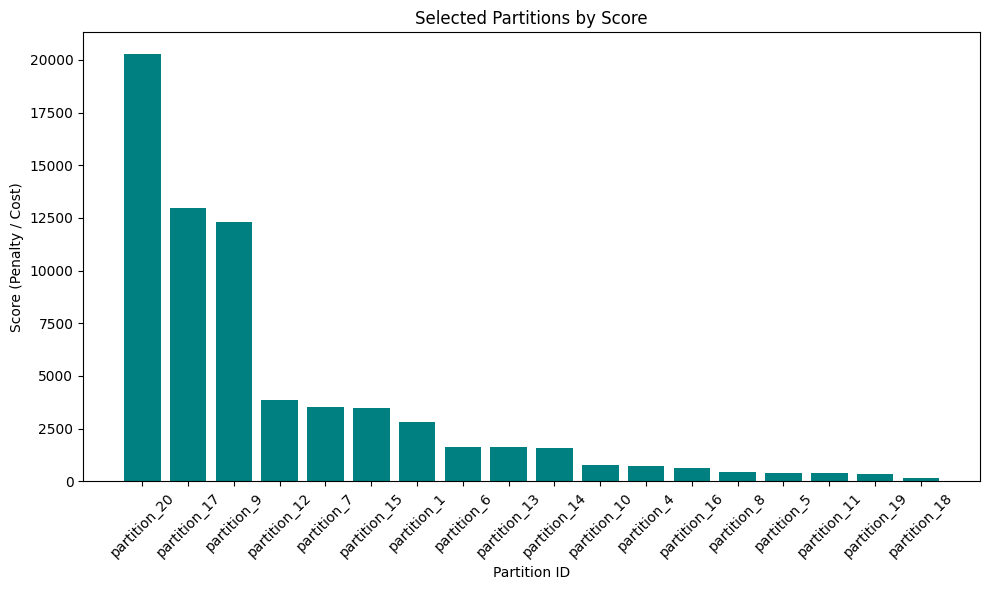

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(selected_df['partition_id'], selected_df['score'], color='teal')
plt.title('Selected Partitions by Score')
plt.xlabel('Partition ID')
plt.ylabel('Score (Penalty / Cost)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("partition_selection_plot.png")
plt.show()
